# Assignment 4

In [6]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC

## Toy Example

Download `SPECTF.train` and `SPECTF.test` from https://archive.ics.uci.edu/ml/machine-learning-databases/spect/

In [49]:
df = pd.read_csv('data/toy_example/SPECTF.train', header=None)
X = df.drop(0, axis=1).to_numpy()
y = df[0].to_numpy()

print(X.shape)
print(y.mean())

(80, 44)
0.5


## Gene Selection for Cancer Classification using Support Vector Machines

In [50]:
def svm_fs(X, y, svm_max_iter=10_000_000, kernel='linear'):
    c_values = []
    chosen_values = []

    X = np.array(X)
    y = np.array(y)

    svm = SVC(kernel=kernel, max_iter=svm_max_iter)

    X_0 = X.copy()
    s = list(range(X.shape[1]))
    r = []

    while s:
        svm.fit(X_0[:, s], y)

        alphas = np.zeros(len(X))
        alphas[svm.support_] = svm.dual_coef_.mean(axis=0)
        w = alphas @ X_0[:, s]
        c = w ** 2
        c_values.append(c)

        f = np.argmin(c)
        chosen_values.append((f, s[f]))
        r.append(s[f])
        s.remove(s[f])

        if len(r) == 3:
            break

    r = np.array(r)[::-1]

    # make scores
    t = np.array([x[0] for x in sorted(enumerate(r), key=lambda x: x[1])])
    return 1 - t / max(t), c_values, chosen_values, r, t

scores, c_values, chosen_values, r, t = svm_fs(X, y)

In [66]:
for i, (c, (f, sf)) in enumerate(zip(c_values, chosen_values)):
    print(f'Values at iteration {i} (Min Index = {f} -> Min Feature = {sf}):')
    print(c)
print('Scores:', {r[i]:scores[t[i]] for i in range(len(r))})

Values at iteration 0 (Min Index = 6 -> Min Feature = 6):
[1.44520471e-02 9.31036479e-04 6.54689861e-04 8.06204748e-03
 5.86451444e-03 1.77924620e-02 4.86225850e-06 5.43094976e-03
 1.49826453e-02 1.48657496e-02 6.97138344e-04 9.77224273e-04
 4.17545170e-03 8.42663959e-03 2.15420801e-04 1.17730638e-02
 2.39179251e-03 8.02971543e-03 4.70479769e-04 6.27418071e-03
 2.33235114e-05 2.54769644e-02 1.48184445e-02 3.82565971e-04
 1.75321014e-02 6.18551175e-03 1.37787579e-02 1.44827782e-02
 7.50097107e-03 1.18985415e-02 4.53055194e-03 7.47534231e-03
 2.41961720e-02 2.18169589e-02 2.70453464e-03 2.56202902e-02
 2.69806660e-03 6.69526136e-03 4.53191092e-03 9.98274145e-03
 2.26578987e-04 1.74257970e-03 6.87290000e-04 9.69436955e-03]
Values at iteration 1 (Min Index = 19 -> Min Feature = 20):
[1.44965825e-02 9.66546878e-04 6.31150072e-04 8.09052730e-03
 5.83768827e-03 1.78154652e-02 5.37305986e-03 1.49305465e-02
 1.47961496e-02 6.85418140e-04 9.83281979e-04 4.15761215e-03
 8.49136036e-03 2.28568222e

## TMGWA

In [58]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
import warnings
from tqdm.auto import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)


def calculate_error_rate(X, y, kf_n_splits=10, knn_n_neighbors=5):
    kf = KFold(n_splits=kf_n_splits, shuffle=True, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=knn_n_neighbors)
    accuracies = cross_val_score(knn, X, y, cv=kf, scoring='accuracy')
    return (1 - accuracies).mean()


def one_wolf_fitness(X, y, wolf, alpha):
    error_rate = calculate_error_rate(X[:, wolf.astype(bool)], y)
    return alpha * error_rate + (1 - alpha) * wolf.mean()


def two_phase_mutation(X, y, wolf, fitness, alpha, mutation_prob):
    one_positions = np.argwhere(wolf == 1).T[0]
    for i in one_positions:
        r = np.random.rand()
        if r < mutation_prob:
            wolf_mutated = wolf.copy()
            wolf_mutated[i] = 0
            mutated_fitness = one_wolf_fitness(X, y, wolf_mutated, alpha)
            if mutated_fitness < fitness:
                fitness = mutated_fitness
                wolf = wolf_mutated

    zero_positions = np.argwhere(wolf == 0).T[0]
    for i in zero_positions:
        r = np.random.rand()
        if r < mutation_prob:
            wolf_mutated = wolf.copy()
            wolf_mutated[i] = 1
            mutated_fitness = one_wolf_fitness(X, y, wolf_mutated, alpha)
            if mutated_fitness < fitness:
                fitness = mutated_fitness
                wolf = wolf_mutated

    return wolf


def calculate_fitnesses(X, y, wolfs, alpha, two_phase_mutation_prob=None):
    fitnesses = [one_wolf_fitness(X, y, wolf, alpha) for wolf in wolfs]

    if two_phase_mutation_prob:
        alpha_idx = np.argmax(fitnesses)
        new_x_alpha = two_phase_mutation(X, y, wolfs[alpha_idx], fitnesses[alpha_idx], alpha, two_phase_mutation_prob)
        wolfs[alpha_idx], fitnesses[alpha_idx] = new_x_alpha, one_wolf_fitness(X, y, new_x_alpha, alpha)

    return fitnesses


def grey_wolf_fs(X, y, n_agents=5, iterations=30, alpha=0.01, two_phase_mutation_prob=0.1):
    n = X.shape[1]
    wolfs = (np.random.rand(n_agents, n) > .5).astype(float)

    fitnesses = calculate_fitnesses(X, y, wolfs, alpha)
    sorted_index = np.argsort(fitnesses)
    x_alpha, x_beta, x_delta = [wolfs[i] for i in sorted_index[:3]]

    min_fitness = 1
    min_fitness_x_alpha = -1

    wolfs_iter = []
    wolfs_bin_iter = []
    fitnesses_iter = []
    abd_iter = []

    for t in tqdm(range(iterations)):
        x_abd = np.stack([x_alpha, x_beta, x_delta]).copy()

        a = 2 - t * 2 / iterations
        A = np.abs(2 * a * np.random.rand(3, n) - a)
        C = 2 * np.random.rand(3, n)

        for wolf_ind in sorted_index:
            wolf = wolfs[wolf_ind]
            D = np.abs(C * x_abd - wolf)
            X_123 = x_abd - A * D
            wolfs[wolf_ind] = X_123.mean(axis=0)

        wolfs_iter.append(wolfs)

        x_si = 1 / (1 + np.exp(-wolfs))
        x_binary = np.random.rand(*wolfs.shape) >= x_si
        wolfs[:] = x_binary

        wolfs_bin_iter.append(wolfs)

        fitnesses = calculate_fitnesses(X, y, wolfs, alpha, two_phase_mutation_prob=two_phase_mutation_prob)
        fitnesses_iter.append(fitnesses)
        sorted_index = np.argsort(fitnesses)
        x_alpha, x_beta, x_delta = [wolfs[i] for i in sorted_index[:3]]
        abd_iter.append(sorted_index[:3])

        if min(fitnesses) < min_fitness:
            min_fitness = min(fitnesses)
            min_fitness_x_alpha = x_alpha.copy()

    return min_fitness_x_alpha, min_fitness, wolfs_iter, wolfs_bin_iter, fitnesses_iter, abd_iter

min_fitness_x_alpha, min_fitness, wolfs_iter, wolfs_bin_iter, fitnesses_iter, abd_iter = grey_wolf_fs(X, y, n_agents=5, iterations=3, alpha=0.01, two_phase_mutation_prob=0.1)

  0%|          | 0/3 [00:00<?, ?it/s]

In [62]:
for i, (wolfs, wolfs_bin, fitnesses, (alpha, beta, delta)) in enumerate(zip(wolfs_iter, wolfs_bin_iter, fitnesses_iter, abd_iter)):
    print(f'Values at Iteration {i}:')
    print('')
    for j, (wolf, wolf_bin, fitness) in enumerate(zip(wolfs, wolfs_bin, fitnesses)):
        print(f'Wolf {j}{" (Alpha)" if j==alpha else " (Beta)" if j==beta else " (Delta)" if j==delta else ""}:')
        print(f'Fitness:', fitness)
        print(f'Position:', wolf)
        print(f'Binary Position:', wolf_bin)
        print('')
    print('------------------------------')
    print('')
print('Min Alpha Wolf Binary Position (Result):', min_fitness_x_alpha)
print('Min Alpha Wolf Fitness:', min_fitness)

Values at Iteration 0:

Wolf 0 (Alpha):
Fitness: 0.408125
Position: [1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1.]
Binary Position: [1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1.]

Wolf 1:
Fitness: 0.565125
Position: [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.]
Binary Position: [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.]

Wolf 2 (Delta):
Fitness: 0.520875
Position: [1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
Binary Position: [1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

# Friedman PostHoc Test

rejected null hypothesis
algorithm poly_svm_fs is significantly better than algorithms {'svm_fs', 'reliefF_fs', 'rbf_svm_fs', 'mrmr_fs', 'grey_wolf_fs_New', 'rfe_svm_fs', 'svm_fs_New', 'rbf_svm_fs_New', 'grey_wolf_fs', 'select_fdr_fs'} in terms of test_roc_auc
algorithm poly_svm_fs_New is significantly better than algorithms {'svm_fs', 'reliefF_fs', 'rbf_svm_fs', 'mrmr_fs', 'grey_wolf_fs_New', 'rfe_svm_fs', 'svm_fs_New', 'rbf_svm_fs_New', 'grey_wolf_fs', 'select_fdr_fs'} in terms of test_roc_auc
algorithm rbf_svm_fs is significantly better than algorithms {'reliefF_fs', 'mrmr_fs', 'grey_wolf_fs_New', 'rfe_svm_fs', 'grey_wolf_fs'} in terms of test_roc_auc
algorithm rbf_svm_fs_New is significantly better than algorithms {'reliefF_fs', 'mrmr_fs', 'grey_wolf_fs_New', 'rfe_svm_fs', 'grey_wolf_fs'} in terms of test_roc_auc
algorithm select_fdr_fs is significantly better than algorithms {'reliefF_fs', 'mrmr_fs', 'grey_wolf_fs_New', 'rfe_svm_fs', 'grey_wolf_fs'} in terms of test_roc_auc
algori

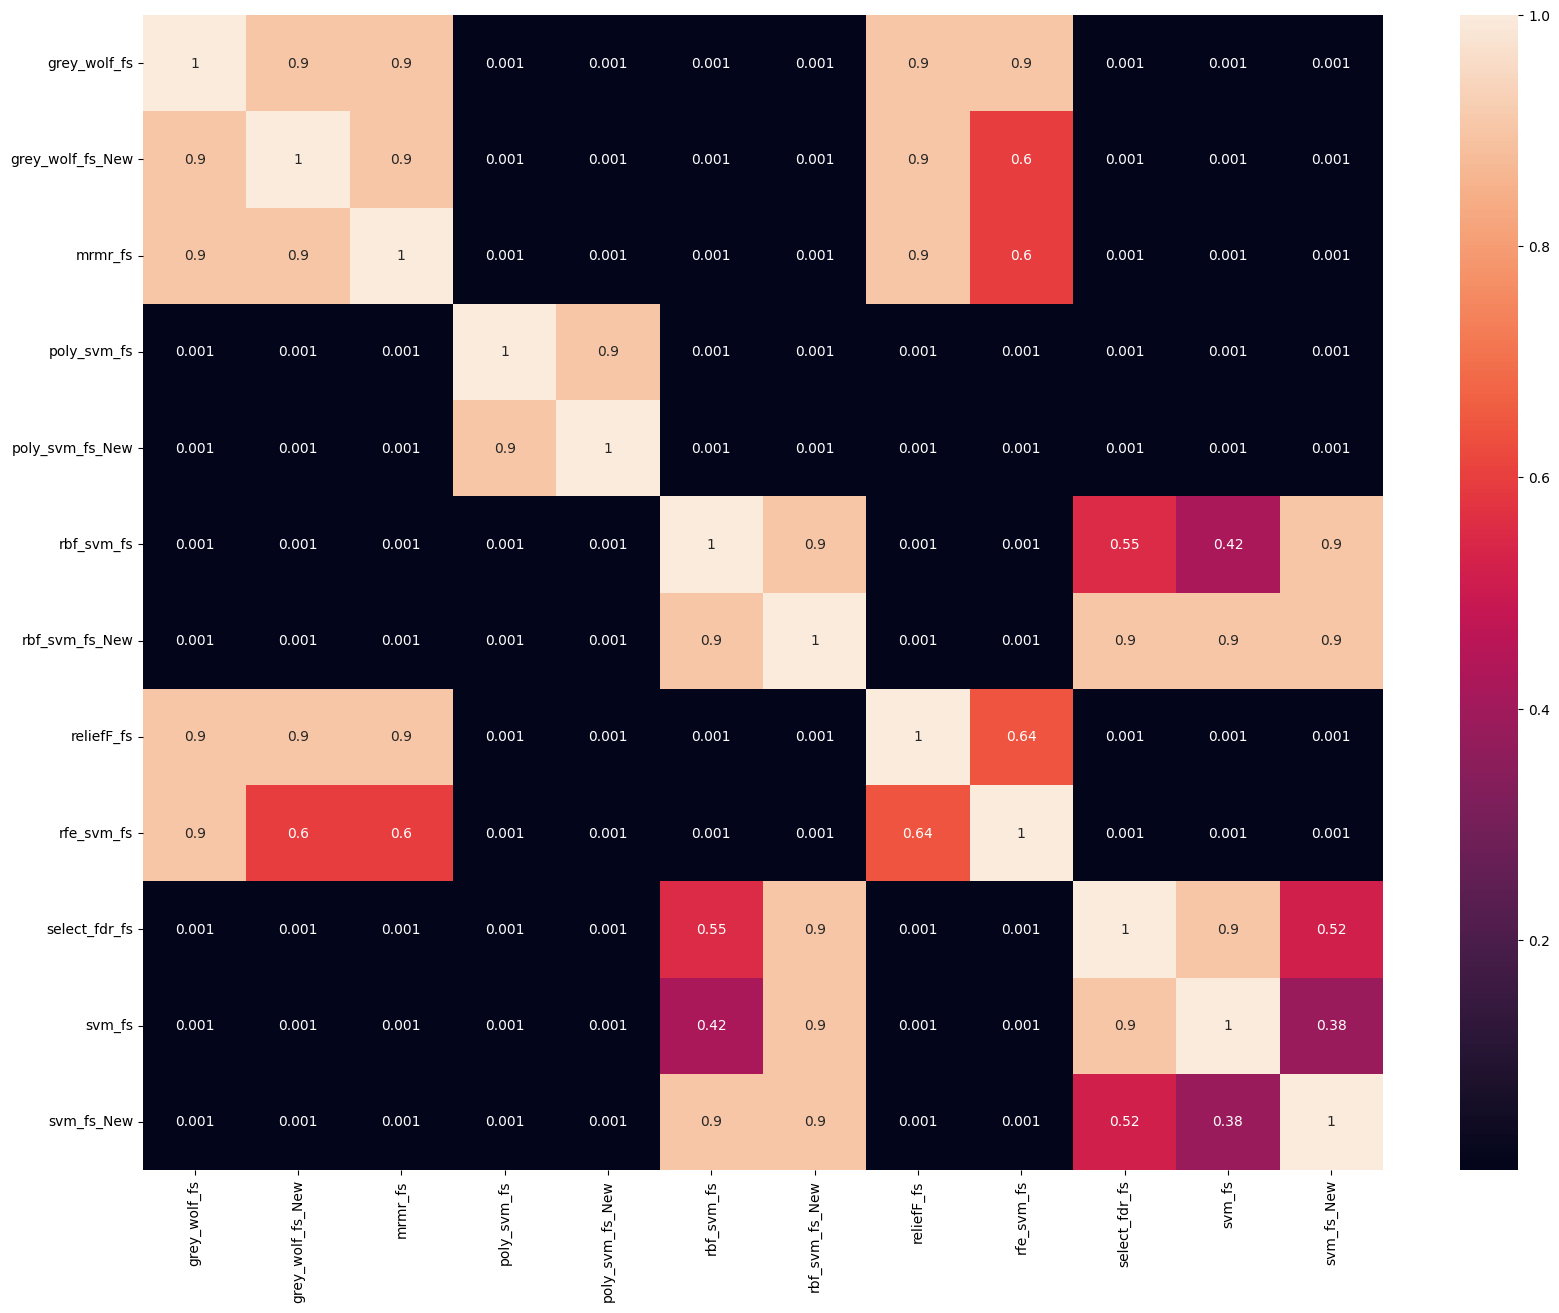

In [63]:
from friedman_posthoc_test import friedman_posthoc_test
friedman_posthoc_test('all_exp_df.csv')